# Reliability assessment Low crested breakwater (Port of Merak)

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")

## Input parameters and their probabilistic distributions

In [2]:
N = 10000 # Number of Monte Carlo runs
zeros = np.zeros(N)

# HEIGHTS i.r.t LAT

#Hydraulic loads
SLR_mean = 0.0 # [m]
Hwaves_mean = 1.28 # [m]

#water levels
DWL_mean = 2 + SLR_mean # [m]
HAT_mean = 1 # [m]
MSL_mean = 0.53 # [m]
hcrest_mean = 4.1 # [m]


#low crested breakwater
B_berm_mean = 1 #width berm [m]
Rc_berm_mean = 2.5 #freeboard crest i.r.t MSL [m]


#overtopping
Tm1_mean = 3.7 # [m]
alpha_mean = 1/2 # [m]
gammaf_mean = 0.55 # [-]
gammaBeta_mean = 1 # [-]
gammav_mean = 1 # [-]
gammab_mean = 1 # [-]
g_mean = 9.81 # [m/s^2]

#vanderMeer (armour breakage berm)
Dn50_mean = 0.5 # [m]
Delta_mean = 1.54 # [-]
Nod_mean = 4.0 # [-]
P_mean = 0.1 # [-]
Sd_mean = 4.0 # [-]
N_mean = 3000 # [-]
Cpl_mean = 6.2 # [-]
Cs_mean = 1.0 # [-]

#guidelines (resistance terms limit state functions)
overtopping_R = 5 # [l/s/m]
vanderMeer_R = 0.5 # [-]
toe_R = Dn50_mean


#Distributions
Delta = scipy.stats.norm(Delta_mean, 0.05*Delta_mean).rvs(N)
Dn50 = scipy.stats.norm(Dn50_mean, 0.05*Dn50_mean).rvs(N)
Nwaves = scipy.stats.norm(N_mean, 0.05*N_mean).rvs(N)
P = scipy.stats.norm(P_mean, 0.05*P_mean).rvs(N)
Cpl = scipy.stats.norm(Cpl_mean,0.4).rvs(N)
Cs = scipy.stats.norm(Cs_mean, 0.08).rvs(N)
vanderMeer = scipy.stats.norm(vanderMeer_R, 0.05*vanderMeer_R).rvs(N)
g = scipy.stats.norm(g_mean, 0.0).rvs(N)
DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
HAT = scipy.stats.norm(HAT_mean, 0.05*HAT_mean).rvs(N)
hcrest = scipy.stats.norm(hcrest_mean, 0.05*hcrest_mean).rvs(N)
alpha = scipy.stats.norm(alpha_mean, 0.05*alpha_mean).rvs(N)
Tm1 = scipy.stats.norm(Tm1_mean, 0.05*Tm1_mean).rvs(N)
gammaf = scipy.stats.norm(gammaf_mean, 0.0*gammaf_mean).rvs(N)
gammaBeta = scipy.stats.norm(gammaBeta_mean, 0.0*gammaBeta_mean).rvs(N)
gammav = scipy.stats.norm(gammav_mean, 0.0*gammav_mean).rvs(N)
gammab = scipy.stats.norm(gammab_mean, 0.0*gammab_mean).rvs(N)
overtopping = scipy.stats.norm(overtopping_R,0.05*overtopping_R).rvs(N)
Sd = scipy.stats.norm(Sd_mean, 0*Sd_mean).rvs(N)
B_berm = scipy.stats.norm(B_berm_mean, 0.05*B_berm_mean).rvs(N)
Rc_berm = scipy.stats.norm(Rc_berm_mean, 0.05*Rc_berm_mean).rvs(N)
toearmour = scipy.stats.lognorm(toe_R, 0.15*toe_R).rvs(N)

## Limit State function

In [3]:
def Overtopping(overtopping,g,hcrest, Tm1, alpha, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammab, gammav, B_berm, Rc_berm):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    
    Rc = hcrest - DWL - SLR
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)
    Rc_low =  -((Rc_berm-DWL) - SLR)
    Kt = 0.4 * (Rc_low / Hwaves) + 0.64 * (B_berm / Hwaves)**-0.31 * (1-np.exp(-0.5*Irri))
    if np.nanmean(Kt) < 0.01:
        Kt = 0.001
    if np.nanmean(Kt) > 1:
        Kt = 1   
    Hwaves = Hwaves*Kt
    
    if any(Rc) > 0.0 and all(Irri) < 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.023/((alpha)**0.5))*gammab*Irri*np.exp(-(2.7*np.abs(Rc/(Irri*Hwaves*gammab*gammaf*gammaBeta*gammav))))**1.3)*1000
        S_overtopping_max = (((g*Hwaves**3)**0.5)*0.09*np.exp(-(1.5*abs(Rc)/(Hwaves*gammaf*gammaBeta*gammav))**1.3))*1000
        #if np.nanmean(S_overtopping) >= np.nanmean(S_overtopping_max):
            #S_overtopping = S_overtopping_max
    elif any(Rc) > 0.0 and all(Irri) > 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(1/(10**0.79))*np.exp(-Rc/((Hwaves*gammab*gammaf)*(0.33+0.022*Irri)))**1.3)*1000
    else:
        S_overtopping = overtopping+1
    S_overtopping = np.array(S_overtopping)
    count_nan = N - np.count_nonzero(~np.isnan(S_overtopping))

    if count_nan > 0.001*N: #ensure all numbers are real
        S_overtopping = overtopping+1
    R_overtopping = overtopping
    LS_overtopping = R_overtopping - S_overtopping 
    return LS_overtopping

def VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves, B_berm, Rc_berm, Tm1):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)
    xi = ((Cpl/Cs)*P**0.31*((alpha)**0.5))**(1/(P+0.5))
    Rc_low =  -((Rc_berm-DWL) - SLR)
    Kt = 0.4 * (Rc_low / Hwaves) + 0.64 * (B_berm / Hwaves)**-0.31 * (1-np.exp(-0.5*Irri))
    if np.nanmean(Kt) < 0.01:
        Kt = 0.001
    if np.nanmean(Kt) > 1:
        Kt = 1   
    Hwaves = Hwaves*Kt
    
    if np.nanmean(Irri) < np.nanmean(xi):
        S_Meer = Hwaves/(Delta*Cpl*(P**0.18)*(1/(np.sqrt(Irri)))*((Sd/np.sqrt(abs(Nwaves)))**0.2))
    elif np.nanmean(Irri) > np.nanmean(xi):
        S_Meer = Hwaves/(Delta*Cs*(1/(P**0.13))*(Irri**P)*((Sd/(np.sqrt(abs(Nwaves))**0.5))**0.2)*(1/alpha)**0.5)
    R_Meer = vanderMeer
    LS_Meer = R_Meer - S_Meer
    return LS_Meer

def Toe_armour(SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta, B_berm, Rc_berm, Tm1):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)

    Rc_low =  -((Rc_berm-DWL) - SLR)
    Kt = 0.4 * (Rc_low / Hwaves) + 0.64 * (B_berm / Hwaves)**-0.31 * (1-np.exp(-0.5*Irri))
    if np.nanmean(Kt) < 0.01:
        Kt = 0.001
    if np.nanmean(Kt) > 1:
        Kt = 1
    Hwaves = Hwaves*Kt

    htoe = DWL- HAT + SLR
    if np.nanmean(htoe)/np.nanmean(Kt*Hwaves) < 2:
        S_toe = (Hwaves/((((0.24*(htoe/Dn50)+1.6))*Delta*Dn50)))**(1/0.15)
        R_toe = toearmour
        LS_toe = R_toe - S_toe 
    else:
        LS_toe = 1
    return LS_toe



N_overtopping = np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammab, gammav, B_berm, Rc_berm), zeros)
N_vanderMeer = np.less_equal(VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves, B_berm, Rc_berm, Tm1), zeros)
N_toearmour = np.less_equal(Toe_armour(SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta, B_berm, Rc_berm, Tm1), zeros)

failure_overtopping = np.sum(N_overtopping) / float(N)
failure_vanderMeer = np.sum(N_vanderMeer) / float(N)
failure_toearmour = np.sum(N_toearmour) / float(N)

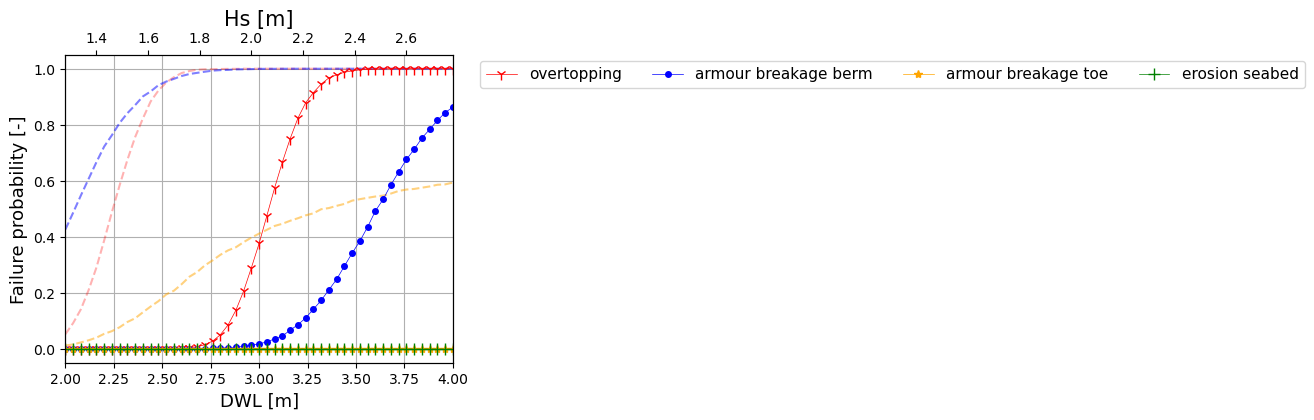

In [4]:
list_overtopping = [] # empty list for conditional failure probabilities
list_vanderMeer = [] # empty list for conditional failure probabilities
list_toearmour = [] # empty list for conditional failure probabilities

N_vertical = 50 #Number of points on horizontal axis

#Min and max values for the different loads
SLR_max = 2 
SLR_min = 0

Hwaves_max = 3 # offshore wave heigth
Hwaves_min = 0.5

SLR_range =np.arange(SLR_min,1.001*SLR_max ,(SLR_max-SLR_min)/N_vertical)
Hwaves_range = np.arange(Hwaves_min,1.001*Hwaves_max,(Hwaves_max-Hwaves_min)/N_vertical)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)


#Choose type of hydraulic loading which will gradually increase
# 1 = rising water levels (sea level rise)
# 2 = rising wave height
# 3 = combination of both when incoming waves are depth-limited

x = 3

if x == 1:
    a = SLR_range
    c = scipy.stats.norm(Hwaves_mean, 0.0).rvs(N)
    d = a + DWL_mean
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    title = 'Pf vs DWL' 
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
elif x == 2:
    a = scipy.stats.norm(SLR_mean, 0.0).rvs(N)
    c = Hwaves_range
    d = c 
    ax1.set_xlim(Hwaves_min,  Hwaves_max)
    title = 'Pf vs Hs'
    xas = 'Hs [m]'
    yas = 'Failure probability [-]'
elif x == 3:
    DWL = scipy.stats.norm(DWL_mean, 0.0*DWL_mean).rvs(N)
    a = SLR_range 
    c =  (Hwaves_mean + 0.75*SLR_range)
    d = a + DWL_mean
    title = ''
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
    ax2 = ax1.twiny()
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
    ax2.set_xlabel('Hs [m]', size = 15)


for i in range(len(d)):
    SLR_mean = a[i]
    Hwaves_mean = c[i]
    failure_overtopping = np.sum(np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammab, gammav, B_berm, Rc_berm), zeros)) / float(N)
    failure_vanderMeer = np.sum(np.less_equal(VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves, B_berm, Rc_berm, Tm1), zeros)) / float(N)
    failure_toearmour = np.sum(np.less_equal(Toe_armour( SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta, B_berm, Rc_berm, Tm1), zeros)) / float(N)
    list_overtopping.append(failure_overtopping)
    list_vanderMeer.append(failure_vanderMeer)
    list_toearmour.append(failure_toearmour)

#conditional failure probabilities extracted from the revetment file 'Reliability_revetment_Merak'
old_total =[0.46189853862999997, 0.54032353948, 0.6201321609999999, 0.698753334124, 0.77223108331, 0.838445271985, 0.886039966384, 0.925695909055, 0.9532469377, 0.971727964, 0.984720519664, 0.991938206596, 0.996190785038, 0.99816799112, 0.999136149264, 0.9996918922, 0.999884865358, 0.99996263701, 0.99998497292, 0.999991157552, 0.9999966775, 0.999998365528, 0.9999993879652096, 1.0, 0.9999999216362015, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_overflow =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0005, 0.0007, 0.0019, 0.0025, 0.0051, 0.0091, 0.0153, 0.0237, 0.043, 0.0712, 0.1006, 0.1426, 0.2007, 0.2546, 0.3328, 0.4172, 0.4937, 0.5719, 0.6482, 0.7209, 0.7782, 0.8351, 0.8782, 0.9167, 0.9421, 0.9611, 0.977]
old_toearmour=[0.0115, 0.0154, 0.0225, 0.0302, 0.0395, 0.0531, 0.0628, 0.0767, 0.0955, 0.1087, 0.1301, 0.1507, 0.1698, 0.1938, 0.2072, 0.2305, 0.2571, 0.2738, 0.2978, 0.3156, 0.3355, 0.3514, 0.3624, 0.3807, 0.3969, 0.4112, 0.4248, 0.4385, 0.4463, 0.457, 0.466, 0.4763, 0.4836, 0.4982, 0.5024, 0.5103, 0.5172, 0.5289, 0.5342, 0.539, 0.5436, 0.5468, 0.5541, 0.5635, 0.5685, 0.5706, 0.5751, 0.5795, 0.5856, 0.587, 0.5933]
old_erosion =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
old_Meer =[0.4259, 0.486, 0.5476, 0.6069, 0.6661, 0.7219, 0.7626, 0.8065, 0.8412, 0.87, 0.9011, 0.9188, 0.9411, 0.954, 0.9638, 0.974, 0.9811, 0.9853, 0.9893, 0.9932, 0.995, 0.9958, 0.9976, 0.9981, 0.9987, 0.9994, 0.9996, 0.9997, 0.9999, 0.9999, 1.0, 1.0, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_overtopping =[0.0518, 0.0917, 0.141, 0.2098, 0.2898, 0.3865, 0.4878, 0.5841, 0.6745, 0.756, 0.8224, 0.8831, 0.9221, 0.9506, 0.9699, 0.9846, 0.9918, 0.9965, 0.998, 0.9981, 0.999, 0.9994, 0.9996, 1.0, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]    
erosion = np.zeros(51) #effect of low crested breakwater on erosion assumed to be negligible


ax1.plot(d,old_overtopping, linestyle = '--', color = 'red', alpha = 0.3)
ax1.plot(d,old_Meer, linestyle = '--', color = 'blue', alpha = 0.5)
ax1.plot(d,old_toearmour, linestyle = '--', color = 'orange', alpha = 0.5)
ax1.plot(d,list_overtopping, label = 'overtopping', color = 'red',linewidth = 0.5, marker ='1', markersize = '8')
ax1.plot(d,list_vanderMeer, label = 'armour breakage berm', color = 'blue', linewidth = 0.5, marker ='.', markersize = '8')
ax1.plot(d,list_toearmour, label = 'armour breakage toe', color = 'orange', linewidth = 0.5, marker ='*', markersize = '6')
ax1.plot(d,old_erosion, label = 'erosion seabed', color = 'green', linewidth = 0.5, marker ='+', markersize = '8')



ax1.set_title(title, size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size=13)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 4,  prop={"size":11})
plt.show()

#Note: error occures for Rc_berm > 3.0 m + MSL. error has not been resolved as greater dimensions have been assumed to be unrealistic anyhow.

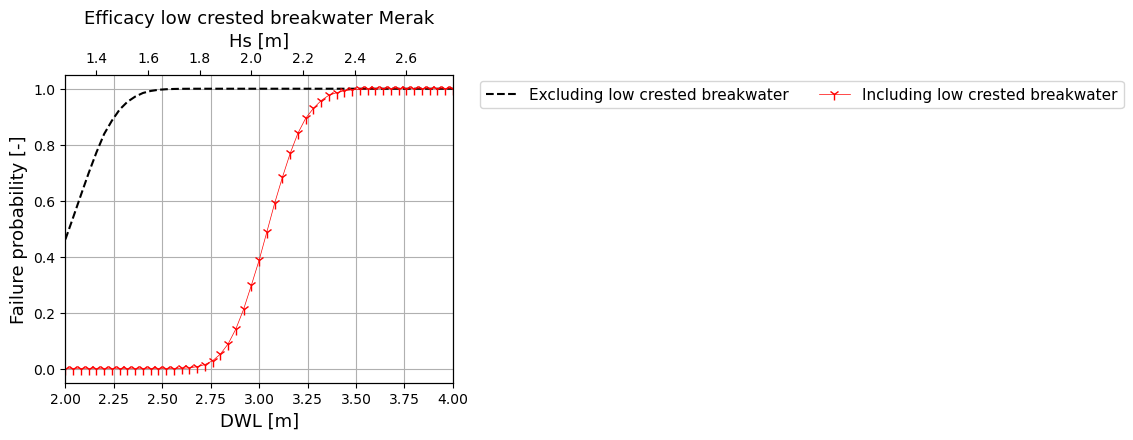

In [5]:
list_new = []

#Combining old failure probabilities for unaffected limit state functions with the newly computed ones for the affected ones
for i in range(N_vertical+1):
    Pf_layer1 = 1-((1-list_toearmour[i])*(1-list_vanderMeer[i])) #Failure tree armour breakage (OR gates)
    Pf_independent = 1-((1-old_overflow[i])*(1-list_overtopping[i])*(1-Pf_layer1)*(1-erosion[i])) #Failure top event (failure revetment)
    list_new.append(Pf_independent)
    
#reiterate wave height to ensure correct increase of legend 
Hwaves_mean = 1.28

fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
ax2.set_xlabel('Hs [m]', size = 13)
ax1.plot(d,old_total, label = 'Excluding low crested breakwater', linestyle = '--', color = 'black')
ax1.plot(d,list_new, label = 'Including low crested breakwater', color = 'red',linewidth = 0.5, marker ='1', markersize = '8')
ax1.set_title('Efficacy low crested breakwater Merak', size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size=13)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 2,  prop={"size":11})
plt.show()
